In [1]:
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="Tennis_Windows_x86_64\Tennis.exe", no_graphics = True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [2]:
import torch
import numpy as np
from collections import deque
import progressbar as pb
import matplotlib.pyplot as plt
from utils import OUprocess, Reply_buffer
from Tennis_agent import SelfPlay_Agent

using device:  cpu


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('states shape: ',states.shape)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
states shape:  (2, 24)
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


In [4]:
T_max = 1000
max_buffer = 15000 # int(1.e+6) too large, for 1000 episodes the lengs was 38051
buffer = Reply_buffer(max_buffer)
noise_decay = 0.999
noise_lvl = 0.5
ouA = OUprocess(action_size, theta=0.15, sigma=noise_lvl)
ouB = OUprocess(action_size, theta=0.15, sigma=noise_lvl)
batch_size = 128 #512 is bad; 64 is better (w. lr 2e-4)
update_steps = 5
agent = SelfPlay_Agent(state_size, action_size, num_agents, lr_act=5.e-4, lr_crit=5.e-4)

In [5]:
nr_episodes = 1200
GD_steps = 20
widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar()]#, ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=nr_episodes).start()
min_buffer = num_agents*batch_size
assert min_buffer<max_buffer, 'minimal length of buffer for update (min_buffer) smaller than buffer memory (max_buffer)!'
ACloss = []
l_exists = False
e_score = np.zeros(nr_episodes)
rolling_avg = np.zeros(nr_episodes)
rolling_window = deque(maxlen=100)
for i in range(nr_episodes):                                         # play game for nr_episodes episodes
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    t=0
    while t<T_max:
        t+=1
        # select action
        actA  = agent.act(states[0]).data.cpu().numpy() + ouA.noise()
        actB = agent.act(states[1]).data.cpu().numpy() + ouB.noise()
        actions = [actA, actB] # select an action (for each agent)
        # execute and observe
        #actions = [np.array([0.1,1]),np.array([0.1,1])]
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        # store in replay buffer
        samples = [states, np.asarray(actions), np.asarray(rewards), next_states, dones]
        buffer.store(samples)
        # roll over states to next time step
        states = next_states                               
        # keep track of scores
        scores += env_info.rewards                         # update the score (for each agent)
        # Update agents
        if ((t-1) % update_steps == 0) and len(buffer.buffer) > num_agents*batch_size:
#             print('Updating networks at time ',t-1)
            l_exists = True
            for a_i in range(num_agents): #ideally you would like to sample the agents randomly 
                for ep in range(GD_steps):
                    minibatch = buffer.get_batch(batch_size)  # get batch of size (batch_size x 4) where the 2nd dim corresponds to (s,a,r,s')
                    closs = agent.update_critic(minibatch,a_i)
                    aloss = agent.update_actor(minibatch,a_i)
                    ACloss.append([aloss,closs])
                    
        # Update target network
        agent.target_update()
        # exit loop if episode finished
        if np.any(dones):                                  
            break

    ouA.reset()
    ouB.reset()
    ouA.sigma *= noise_decay
    ouB.sigma *= noise_decay
    
    e_score[i] = np.max(scores)
    rolling_window.append(e_score[i])
    rolling_avg[i] = np.mean(np.array(rolling_window))
    if (i+1) % 20 == 0:
        print('Total score (averaged over agents) episode {}: {}'.format(i+1,np.mean(scores)))
        print('Score (max over agents) from episode {}: {}'.format(i+1, e_score[i]))
        print('Rolling average score: {}'.format(rolling_avg[i]))
        print('Noise level: ',ouA.sigma,ouB.sigma)
        if l_exists:
            print("Actor loss: {} | Critic loss: {}".format(*ACloss[-1]))
    
    # update progress widget bar
    timer.update(i+1)
    
timer.finish()

Total score (averaged over agents) episode 20: -0.004999999888241291
Score (max over agents) from episode 20: 0.0
Rolling average score: 0.0
Noise level:  0.49009443241476736 0.49009443241476736
Actor loss: 0.059586331248283386 | Critic loss: 0.00011505923612276092


Total score (averaged over agents) episode 40: -0.004999999888241291
Score (max over agents) from episode 40: 0.0
Rolling average score: 0.002500000037252903
Noise level:  0.4803851053679059 0.4803851053679059
Actor loss: -0.02063775807619095 | Critic loss: 0.00013982804375700653


Total score (averaged over agents) episode 60: -0.004999999888241291
Score (max over agents) from episode 60: 0.0
Rolling average score: 0.0016666666915019354
Noise level:  0.47086813111158415 0.47086813111158415
Actor loss: -0.044451385736465454 | Critic loss: 0.00012155063450336456


Total score (averaged over agents) episode 80: 0.04500000085681677
Score (max over agents) from episode 80: 0.09000000171363354
Rolling average score: 0.007375000114552677
Noise level:  0.4615396989186682 0.4615396989186682
Actor loss: -0.021676890552043915 | Critic loss: 6.832431245129555e-05


Total score (averaged over agents) episode 100: -0.004999999888241291
Score (max over agents) from episode 100: 0.0
Rolling average score: 0.007900000121444463
Noise level:  0.4523960735568548 0.4523960735568548
Actor loss: -0.00855858251452446 | Critic loss: 8.369109309569467e-06


Total score (averaged over agents) episode 120: 0.04500000085681677
Score (max over agents) from episode 120: 0.09000000171363354
Rolling average score: 0.011700000185519456
Noise level:  0.4434335937930322 0.4434335937930322
Actor loss: -0.004872224293649197 | Critic loss: 5.434524791780859e-05


Total score (averaged over agents) episode 140: -0.004999999888241291
Score (max over agents) from episode 140: 0.0
Rolling average score: 0.014600000232458115
Noise level:  0.43464867092727333 0.43464867092727333
Actor loss: -0.008262475952506065 | Critic loss: 4.282582813175395e-05


Total score (averaged over agents) episode 160: 0.04500000085681677
Score (max over agents) from episode 160: 0.09000000171363354
Rolling average score: 0.026000000424683093
Noise level:  0.42603778735586995 0.42603778735586995
Actor loss: -0.012661398388445377 | Critic loss: 7.21024071026477e-06


Total score (averaged over agents) episode 180: -0.004999999888241291
Score (max over agents) from episode 180: 0.0
Rolling average score: 0.0287000004760921
Noise level:  0.4175974951628368 0.4175974951628368
Actor loss: -0.016294172033667564 | Critic loss: 4.80785138279316e-06


Total score (averaged over agents) episode 200: 0.04500000085681677
Score (max over agents) from episode 200: 0.09000000171363354
Rolling average score: 0.04220000069588423
Noise level:  0.409324414739318 0.409324414739318
Actor loss: -0.02418597601354122 | Critic loss: 8.874225022736937e-05


Total score (averaged over agents) episode 220: -0.004999999888241291
Score (max over agents) from episode 220: 0.0
Rolling average score: 0.04980000082403421
Noise level:  0.4012152334303457 0.4012152334303457
Actor loss: -0.02529607154428959 | Critic loss: 2.7883654183824547e-05


Total score (averaged over agents) episode 240: -0.004999999888241291
Score (max over agents) from episode 240: 0.0
Rolling average score: 0.05070000084117055
Noise level:  0.39326670420840737 0.39326670420840737
Actor loss: -0.031505897641181946 | Critic loss: 4.10915890824981e-05


Total score (averaged over agents) episode 260: -0.004999999888241291
Score (max over agents) from episode 260: 0.0
Rolling average score: 0.05190000085160136
Noise level:  0.38547564437329124 0.38547564437329124
Actor loss: -0.039027899503707886 | Critic loss: 0.00010451995331095532


Total score (averaged over agents) episode 280: 0.04500000085681677
Score (max over agents) from episode 280: 0.10000000149011612
Rolling average score: 0.06050000099465251
Noise level:  0.3778389342776898 0.3778389342776898
Actor loss: -0.0377049520611763 | Critic loss: 0.00010982700769091025


Total score (averaged over agents) episode 300: 0.04500000085681677
Score (max over agents) from episode 300: 0.10000000149011612
Rolling average score: 0.055700000915676354
Noise level:  0.37035351607804984 0.37035351607804984
Actor loss: -0.03457674756646156 | Critic loss: 9.944209159584716e-05


Total score (averaged over agents) episode 320: 0.09500000160187483
Score (max over agents) from episode 320: 0.10000000149011612
Rolling average score: 0.06250000102445483
Noise level:  0.36301639251017037 0.36301639251017037
Actor loss: -0.04567873105406761 | Critic loss: 0.00017168300109915435


Total score (averaged over agents) episode 340: 0.04500000085681677
Score (max over agents) from episode 340: 0.10000000149011612
Rolling average score: 0.07520000122487545
Noise level:  0.35582462568905665 0.35582462568905665
Actor loss: -0.04734156280755997 | Critic loss: 0.00016393123951274902


Total score (averaged over agents) episode 360: 0.04500000085681677
Score (max over agents) from episode 360: 0.10000000149011612
Rolling average score: 0.0754000012204051
Noise level:  0.34877533593255056 0.34877533593255056
Actor loss: -0.050237610936164856 | Critic loss: 4.805184289580211e-05


Total score (averaged over agents) episode 380: 0.04500000085681677
Score (max over agents) from episode 380: 0.09000000171363354
Rolling average score: 0.07460000120103359
Noise level:  0.3418657006082664 0.3418657006082664
Actor loss: -0.04526805877685547 | Critic loss: 0.00012474198592826724


Total score (averaged over agents) episode 400: 0.04500000085681677
Score (max over agents) from episode 400: 0.10000000149011612
Rolling average score: 0.08370000133290886
Noise level:  0.33509295300337016 0.33509295300337016
Actor loss: -0.04594222083687782 | Critic loss: 0.00017301693151239306


Total score (averaged over agents) episode 420: 0.04500000085681677
Score (max over agents) from episode 420: 0.10000000149011612
Rolling average score: 0.07940000124275684
Noise level:  0.32845438121674997 0.32845438121674997
Actor loss: -0.054274898022413254 | Critic loss: 6.686931737931445e-05


Total score (averaged over agents) episode 440: 0.1450000023469329
Score (max over agents) from episode 440: 0.20000000298023224
Rolling average score: 0.07970000123605132
Noise level:  0.32194732707313334 0.32194732707313334
Actor loss: -0.053327612578868866 | Critic loss: 7.986556011019275e-05


Total score (averaged over agents) episode 460: 0.09500000160187483
Score (max over agents) from episode 460: 0.10000000149011612
Rolling average score: 0.08650000136345624
Noise level:  0.3155691850587174 0.3155691850587174
Actor loss: -0.04395201429724693 | Critic loss: 9.89139371085912e-05


Total score (averaged over agents) episode 480: 0.09500000160187483
Score (max over agents) from episode 480: 0.10000000149011612
Rolling average score: 0.08910000137984753
Noise level:  0.30931740127788554 0.30931740127788554
Actor loss: -0.050489045679569244 | Critic loss: 0.00018514950352255255


Total score (averaged over agents) episode 500: 0.09500000160187483
Score (max over agents) from episode 500: 0.10000000149011612
Rolling average score: 0.0871000013500452
Noise level:  0.3031894724305924 0.3031894724305924
Actor loss: -0.053761325776576996 | Critic loss: 8.996912947623059e-05


Total score (averaged over agents) episode 520: 0.04500000085681677
Score (max over agents) from episode 520: 0.10000000149011612
Rolling average score: 0.08810000136494636
Noise level:  0.2971829448100079 0.2971829448100079
Actor loss: -0.057259559631347656 | Critic loss: 0.00020862941164523363


Total score (averaged over agents) episode 540: -0.004999999888241291
Score (max over agents) from episode 540: 0.0
Rolling average score: 0.08890000138431788
Noise level:  0.29129541332001985 0.29129541332001985
Actor loss: -0.05014776811003685 | Critic loss: 8.685950888320804e-05


Total score (averaged over agents) episode 560: 0.19500000402331352
Score (max over agents) from episode 560: 0.20000000298023224
Rolling average score: 0.09010000137612223
Noise level:  0.2855245205122003 0.2855245205122003
Actor loss: -0.06280704587697983 | Critic loss: 0.00012127196532674134


Total score (averaged over agents) episode 580: -0.004999999888241291
Score (max over agents) from episode 580: 0.0
Rolling average score: 0.10080000154674053
Noise level:  0.27986795564185063 0.27986795564185063
Actor loss: -0.05953650921583176 | Critic loss: 0.00017809862038120627


Total score (averaged over agents) episode 600: -0.004999999888241291
Score (max over agents) from episode 600: 0.0
Rolling average score: 0.10570000162348152
Noise level:  0.27432345374274825 0.27432345374274825
Actor loss: -0.06360955536365509 | Critic loss: 0.0001396358711645007


Total score (averaged over agents) episode 620: 0.19500000309199095
Score (max over agents) from episode 620: 0.20000000298023224
Rolling average score: 0.11240000173449516
Noise level:  0.2688887947202218 0.2688887947202218
Actor loss: -0.06991443037986755 | Critic loss: 8.113669173326343e-05


Total score (averaged over agents) episode 640: 0.1450000023469329
Score (max over agents) from episode 640: 0.19000000320374966
Rolling average score: 0.11550000177696347
Noise level:  0.26356180246219596 0.26356180246219596
Actor loss: -0.07249253243207932 | Critic loss: 0.0002830041921697557


Total score (averaged over agents) episode 660: 0.09500000160187483
Score (max over agents) from episode 660: 0.10000000149011612
Rolling average score: 0.11670000178739429
Noise level:  0.25834034396784594 0.25834034396784594
Actor loss: -0.06810971349477768 | Critic loss: 0.00012072364188497886


Total score (averaged over agents) episode 680: 0.09500000160187483
Score (max over agents) from episode 680: 0.10000000149011612
Rolling average score: 0.10480000160634517
Noise level:  0.2532223284935145 0.2532223284935145
Actor loss: -0.07220224291086197 | Critic loss: 0.00018252340669278055


Total score (averaged over agents) episode 700: -0.004999999888241291
Score (max over agents) from episode 700: 0.0
Rolling average score: 0.10510000159963966
Noise level:  0.24820570671554945 0.24820570671554945
Actor loss: -0.08328768610954285 | Critic loss: 0.00014565499441232532


Total score (averaged over agents) episode 720: 0.04500000085681677
Score (max over agents) from episode 720: 0.10000000149011612
Rolling average score: 0.10230000155046583
Noise level:  0.2432884699097268 0.2432884699097268
Actor loss: -0.08193878829479218 | Critic loss: 0.0002031876938417554


Total score (averaged over agents) episode 740: -0.004999999888241291
Score (max over agents) from episode 740: 0.0
Rolling average score: 0.10060000151395798
Noise level:  0.23846864914692945 0.23846864914692945
Actor loss: -0.09124819189310074 | Critic loss: 0.00015859097766224295


Total score (averaged over agents) episode 760: 0.04500000085681677
Score (max over agents) from episode 760: 0.10000000149011612
Rolling average score: 0.10250000154599548
Noise level:  0.23374431450476132 0.23374431450476132
Actor loss: -0.08548980951309204 | Critic loss: 0.00021756118803750724


Total score (averaged over agents) episode 780: -0.004999999888241291
Score (max over agents) from episode 780: 0.0
Rolling average score: 0.11230000169947743
Noise level:  0.22911357429477971 0.22911357429477971
Actor loss: -0.09402747452259064 | Critic loss: 0.00022127441479824483


Total score (averaged over agents) episode 800: 0.04500000085681677
Score (max over agents) from episode 800: 0.10000000149011612
Rolling average score: 0.11510000174865126
Noise level:  0.2245745743050374 0.2245745743050374
Actor loss: -0.09318934381008148 | Critic loss: 0.00014606966578867286


Total score (averaged over agents) episode 820: 0.3450000053271651
Score (max over agents) from episode 820: 0.4000000059604645
Rolling average score: 0.12920000195503234
Noise level:  0.22012549705763065 0.22012549705763065
Actor loss: -0.0925433337688446 | Critic loss: 0.00020867565763182938


Total score (averaged over agents) episode 840: 0.1450000023469329
Score (max over agents) from episode 840: 0.20000000298023224
Rolling average score: 0.13380000203847886
Noise level:  0.21576456108095607 0.21576456108095607
Actor loss: -0.09413620084524155 | Critic loss: 0.00024342584947589785


Total score (averaged over agents) episode 860: 0.04500000085681677
Score (max over agents) from episode 860: 0.10000000149011612
Rolling average score: 0.135900002066046
Noise level:  0.21149002019638505 0.21149002019638505
Actor loss: -0.09773637354373932 | Critic loss: 0.00020631802908610553


Total score (averaged over agents) episode 880: 0.04500000085681677
Score (max over agents) from episode 880: 0.10000000149011612
Rolling average score: 0.12910000195726754
Noise level:  0.20730016281907002 0.20730016281907002
Actor loss: -0.09898293018341064 | Critic loss: 0.00021105550695210695


Total score (averaged over agents) episode 900: 0.04500000085681677
Score (max over agents) from episode 900: 0.10000000149011612
Rolling average score: 0.12090000184252858
Noise level:  0.20319331127260196 0.20319331127260196
Actor loss: -0.08908720314502716 | Critic loss: 9.695214248495176e-05


Total score (averaged over agents) episode 920: 0.04500000085681677
Score (max over agents) from episode 920: 0.10000000149011612
Rolling average score: 0.11280000172555446
Noise level:  0.199167821117246 0.199167821117246
Actor loss: -0.08608555793762207 | Critic loss: 0.00031749901245348155


Total score (averaged over agents) episode 940: 0.04500000085681677
Score (max over agents) from episode 940: 0.10000000149011612
Rolling average score: 0.1110000016912818
Noise level:  0.19522208049148515 0.19522208049148515
Actor loss: -0.08743123710155487 | Critic loss: 0.0002024521236307919


Total score (averaged over agents) episode 960: 0.04500000085681677
Score (max over agents) from episode 960: 0.09000000171363354
Rolling average score: 0.10710000166669488
Noise level:  0.1913545094666089 0.1913545094666089
Actor loss: -0.0854867473244667 | Critic loss: 0.0003154074074700475


Total score (averaged over agents) episode 980: 0.04500000085681677
Score (max over agents) from episode 980: 0.09000000171363354
Rolling average score: 0.10620000168681144
Noise level:  0.18756355941408784 0.18756355941408784
Actor loss: -0.08257119357585907 | Critic loss: 0.00010901366476900876


Total score (averaged over agents) episode 1000: -0.004999999888241291
Score (max over agents) from episode 1000: 0.0
Rolling average score: 0.11150000175461174
Noise level:  0.18384771238548175 0.18384771238548175
Actor loss: -0.07712643593549728 | Critic loss: 0.0002443540724925697


Total score (averaged over agents) episode 1020: 0.04500000085681677
Score (max over agents) from episode 1020: 0.09000000171363354
Rolling average score: 0.11130000175908208
Noise level:  0.18020548050463217 0.18020548050463217
Actor loss: -0.07412628084421158 | Critic loss: 0.00010272710642311722


Total score (averaged over agents) episode 1040: 0.09500000160187483
Score (max over agents) from episode 1040: 0.10000000149011612
Rolling average score: 0.10940000172704459
Noise level:  0.17663540537189637 0.17663540537189637
Actor loss: -0.07160542905330658 | Critic loss: 7.903036021161824e-05


Total score (averaged over agents) episode 1060: 0.04500000085681677
Score (max over agents) from episode 1060: 0.10000000149011612
Rolling average score: 0.11500000178813935
Noise level:  0.17313605748018382 0.17313605748018382
Actor loss: -0.07500855624675751 | Critic loss: 0.00013398472219705582


Total score (averaged over agents) episode 1080: 0.09500000160187483
Score (max over agents) from episode 1080: 0.10000000149011612
Rolling average score: 0.12490000190213323
Noise level:  0.16970603564256243 0.16970603564256243
Actor loss: -0.07740022242069244 | Critic loss: 0.0001847984385676682


Total score (averaged over agents) episode 1100: 0.04500000085681677
Score (max over agents) from episode 1100: 0.10000000149011612
Rolling average score: 0.13560000207275152
Noise level:  0.16634396643120383 0.16634396643120383
Actor loss: -0.08132946491241455 | Critic loss: 0.00012787892774213105


Total score (averaged over agents) episode 1120: 0.04500000085681677
Score (max over agents) from episode 1120: 0.10000000149011612
Rolling average score: 0.15900000240653753
Noise level:  0.16304850362744394 0.16304850362744394
Actor loss: -0.08062531054019928 | Critic loss: 0.00013325376494321972


Total score (averaged over agents) episode 1140: 0.1450000023469329
Score (max over agents) from episode 1140: 0.20000000298023224
Rolling average score: 0.17590000266209244
Noise level:  0.15981832768273851 0.15981832768273851
Actor loss: -0.08705029636621475 | Critic loss: 9.637156472308561e-05


Total score (averaged over agents) episode 1160: 0.04500000085681677
Score (max over agents) from episode 1160: 0.10000000149011612
Rolling average score: 0.1769000026769936
Noise level:  0.15665214519029808 0.15665214519029808
Actor loss: -0.09207580238580704 | Critic loss: 0.00019746868929360062


Total score (averaged over agents) episode 1180: 0.1450000023469329
Score (max over agents) from episode 1180: 0.20000000298023224
Rolling average score: 0.1750000026449561
Noise level:  0.15354868836718968 0.15354868836718968
Actor loss: -0.09359119832515717 | Critic loss: 0.0001763814507285133


Total score (averaged over agents) episode 1200: 0.09500000160187483
Score (max over agents) from episode 1200: 0.10000000149011612
Rolling average score: 0.1689000025577843
Noise level:  0.1505067145466996 0.1505067145466996
Actor loss: -0.0918990895152092 | Critic loss: 0.00035154432407580316


In [6]:
print([torch.mean(trgt-net) for trgt, net in zip(agent.actor_target.parameters(),agent.actor.parameters())])

[tensor(7.8376e-05, grad_fn=<MeanBackward0>), tensor(-2.8805e-05, grad_fn=<MeanBackward0>), tensor(-0.0003, grad_fn=<MeanBackward0>), tensor(-0.0008, grad_fn=<MeanBackward0>), tensor(-0.0002, grad_fn=<MeanBackward0>), tensor(-0.0007, grad_fn=<MeanBackward0>), tensor(-0.0009, grad_fn=<MeanBackward0>), tensor(0.0042, grad_fn=<MeanBackward0>)]


(411760, 2)


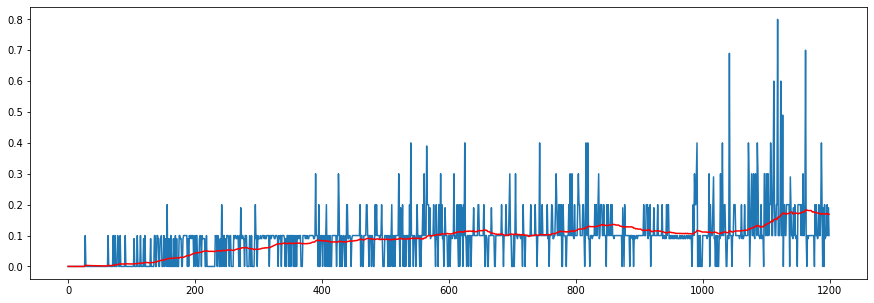

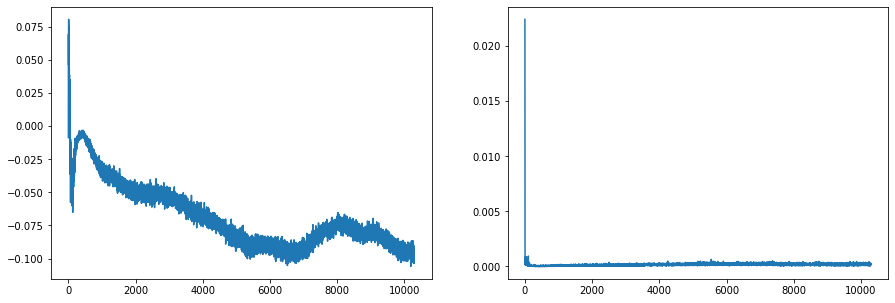

In [7]:
ACloss = np.asarray(ACloss)
print(ACloss.shape)
plt.figure(figsize=(15,5))
plt.plot(e_score)
plt.plot(rolling_avg,'r')
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(ACloss[::GD_steps*num_agents,0])
plt.subplot(122)
plt.plot(ACloss[::GD_steps*num_agents,1])


In [8]:
# env.close()

In [9]:
len(buffer.buffer)

15000

In [10]:
20*512

10240